In [1]:
from manim import *

Manim Community v0.16.0.post0

In [32]:
class ManimSlidesLogo(Scene):
    def construct(self):
        tex_template = TexTemplate()
        tex_template.add_to_preamble(r"\usepackage{fontawesome5}")
        self.camera.background_color = "#ffffff"
        logo_green = "#87c2a5"
        logo_blue = "#525893"
        logo_red = "#e07a5f"
        logo_black = "#343434"
        ds_m = MathTex(r"\mathbb{M}", fill_color=logo_black).scale(7)
        ds_m.shift(2.25 * LEFT + 1.5 * UP)
        slides = MathTex(r"\mathbb{S}\text{lides}", fill_color=logo_black).scale(4)
        slides.next_to(ds_m, DOWN)
        slides.shift(DOWN)
        book = Tex(
            r"\faStepBackward\faStepForward",
            fill_color=logo_black,
            tex_template=tex_template,
        ).scale(4)
        book.next_to(ds_m, LEFT)
        book.shift(LEFT + 0.5 * DOWN)
        circle = Circle(color=logo_green, fill_opacity=1).shift(LEFT)
        square = Square(color=logo_blue, fill_opacity=1).shift(UP)
        triangle = Triangle(color=logo_red, fill_opacity=1).shift(RIGHT)
        logo = VGroup(triangle, square, circle, ds_m, slides, book)  # order matters
        logo.move_to(ORIGIN)
        self.add(logo)

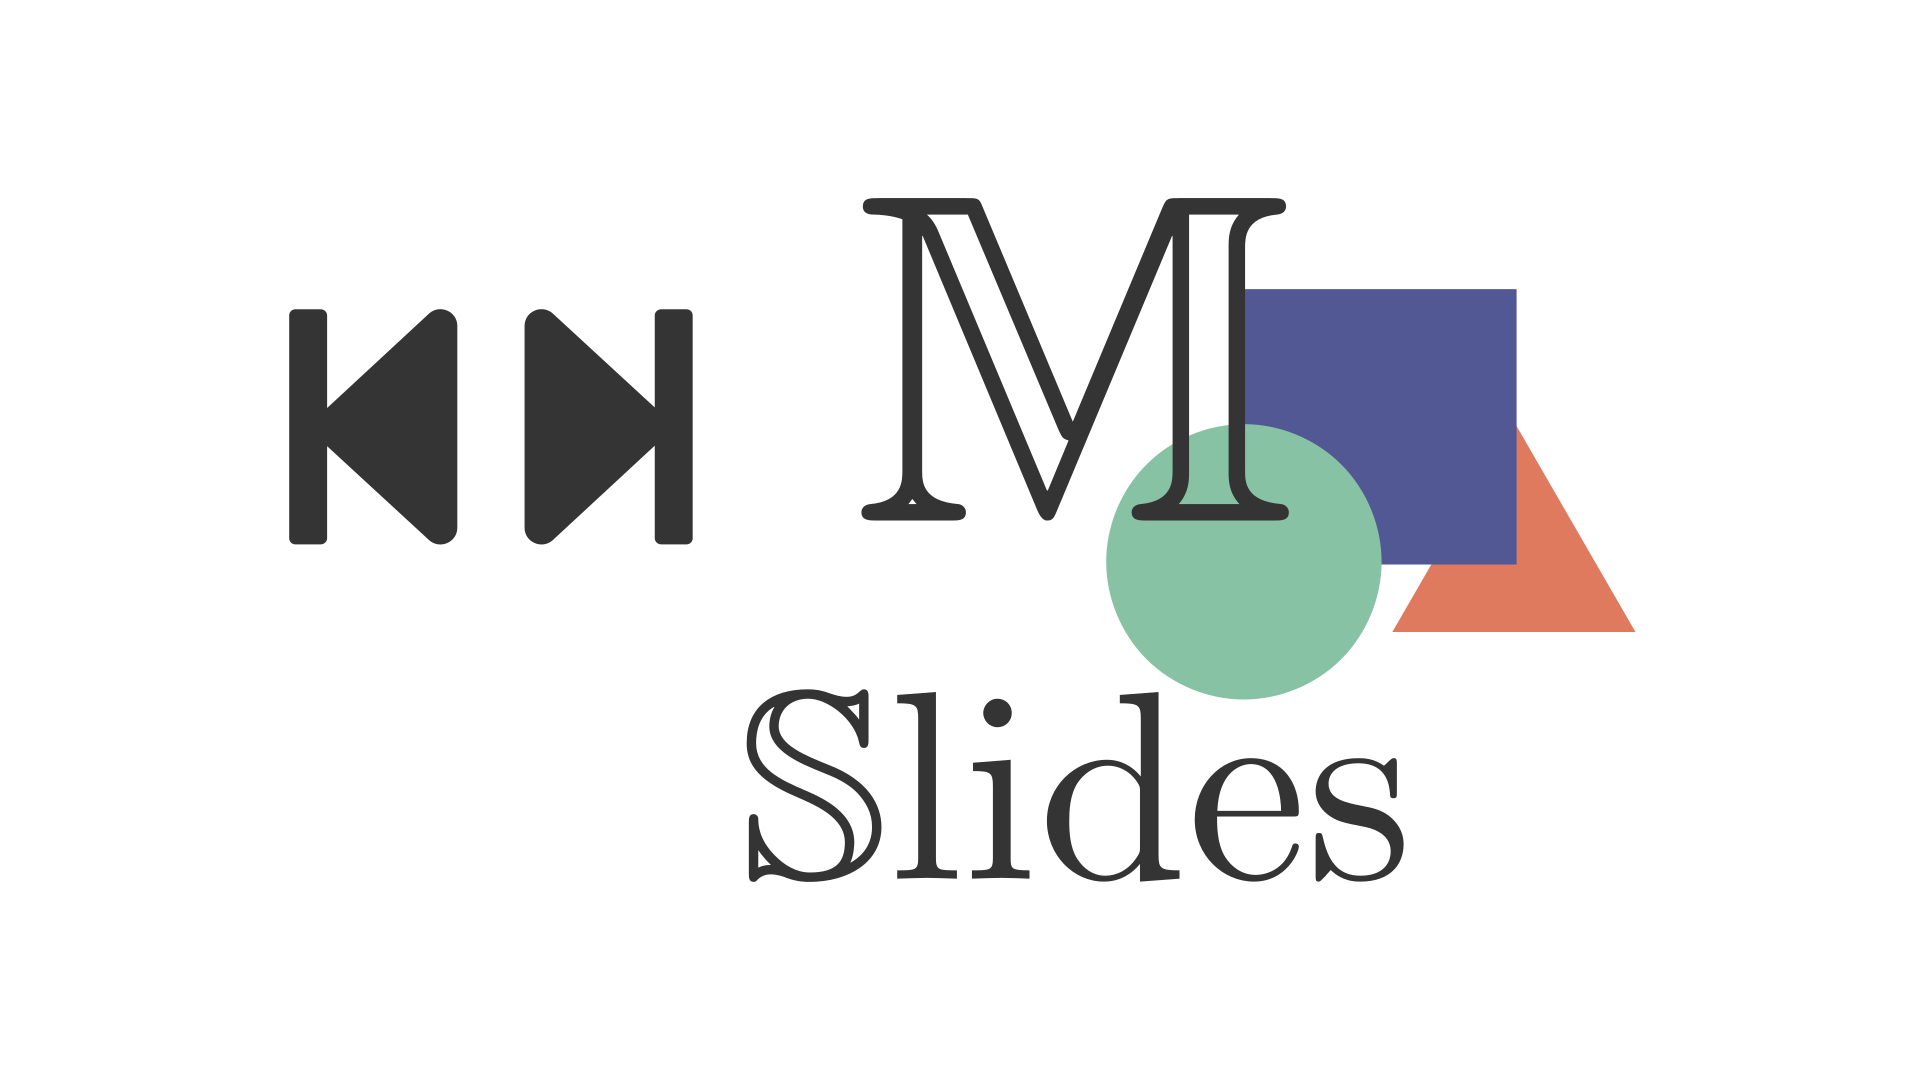

In [33]:
%manim -qh -v WARNING -s --format=png ManimSlidesLogo

Some text